In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
data_dir = Path() / "results"
figs_dir = Path() / "figs"
figs_dir.mkdir(exist_ok=True)

split_mfq_dir = figs_dir / "split_mfq"
split_mfq_dir.mkdir(exist_ok=True)

# Loading dataframes

In [3]:
corr_df = pd.read_csv(data_dir / "correlations.csv")

corr_df.head(2)

,agent,scale,foundation,condition,q1,q2,pearson_r,pearson_p,spearman_r,spearman_p
0,Claude 2.1,MFQ,Harm,overall,emotionally,weak,0.283313,0.000310,0.298943,0.000136
1,Claude 2.1,MFQ,Harm,qv,emotionally,weak,0.292035,0.003357,0.304762,0.002161


In [4]:
cronbach_df = pd.read_csv(data_dir / "cronbach.csv")

cronbach_df.head(2)

,scale,foundation,condition,agent,alpha
0,MFQ,Harm,overall,Claude 2.1,0.293878
1,MFQ - Part 1,Harm,overall,Claude 2.1,0.470532


In [5]:
# add rows with human scores for MFV foundatios: care (e) = 0.85; Care (p) = 0.84; Fairness = 0.71; Liberty = 0.83; Authority = 0.86; Loyalty = .89; Purity = 0.79
df_humans = pd.DataFrame(
    [
        ["Care (e)", 0.85],
        ["Care (p)", 0.84],
        ["Fairness", 0.71],
        ["Liberty", 0.83],
        ["Authority", 0.86],
        ["Loyalty", 0.89],
        ["Purity", 0.79],
    ],
    columns=["foundation", "alpha"],
)
df_humans["scale"] = "MFV"
df_humans["agent"] = "Human"
df_humans["condition"] = "overall"

In [6]:
# join
cronbach_df = pd.concat([cronbach_df, df_humans], ignore_index=True)

# create type_agent column
cronbach_df["type_agent"] = np.where(
    cronbach_df["agent"] == "Human", "Human", "AI"
)

Fixing foundation namings

In [7]:
def standardize_foundation(col: pd.Series):
    replace = {"Harm": "Care", "Ingroup": "Loyalty"}
    return col.replace(replace)


corr_df["foundation"] = standardize_foundation(corr_df.foundation)
cronbach_df["foundation"] = standardize_foundation(cronbach_df.foundation)

In [8]:
cronbach_df.scale.unique()

array(['MFQ', 'MFQ - Part 1', 'MFQ - Part 2', 'MFV'], dtype=object)

# Plotting settings

In [9]:
# set axis lines to light gray
plt.rcParams["axes.edgecolor"] = "lightgray"
# tick labels to dark gray
plt.rcParams["ytick.color"] = "dimgrey"
plt.rcParams["xtick.color"] = "dimgrey"

# set grid on
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = "lightgray"

In [10]:
# creating y values for agent for placement

conds = (
    ((cronbach_df["agent"] == "Claude 2.1") & (cronbach_df["scale"] == "MFV")),
    ((cronbach_df["agent"] == "Human") & (cronbach_df["scale"] == "MFV")),
    ((cronbach_df["agent"] == "GPT-4") & (cronbach_df["scale"] == "MFV")),
    ((cronbach_df["agent"] == "Claude 2.1") & (cronbach_df["scale"] == "MFQ")),
    ((cronbach_df["agent"] == "Human") & (cronbach_df["scale"] == "MFQ")),
    ((cronbach_df["agent"] == "GPT-4") & (cronbach_df["scale"] == "MFQ")),
)

cronbach_df["agent_instrument_y"] = np.select(
    conds,
    [0,1,2,4,5,6],
)

cronbach_df_simple = cronbach_df.query("scale in ['MFQ', 'MFV']")
cronbach_df_simple

,scale,foundation,condition,agent,alpha,type_agent,agent_instrument_y
0,MFQ,Care,overall,Claude 2.1,0.293878,AI,4
3,MFQ,Care,qv,Claude 2.1,0.195967,AI,4
6,MFQ,Care,vq,Claude 2.1,0.448075,AI,4
9,MFQ,Care,overall,GPT-4,0.756013,AI,6
12,MFQ,Care,qv,GPT-4,0.836477,AI,6
...,...,...,...,...,...,...,...
156,MFV,Fairness,overall,Human,0.710000,Human,1
157,MFV,Liberty,overall,Human,0.830000,Human,1
158,MFV,Authority,overall,Human,0.860000,Human,1
159,MFV,Loyalty,overall,Human,0.890000,Human,1


# Main Plots
## Condition comparison

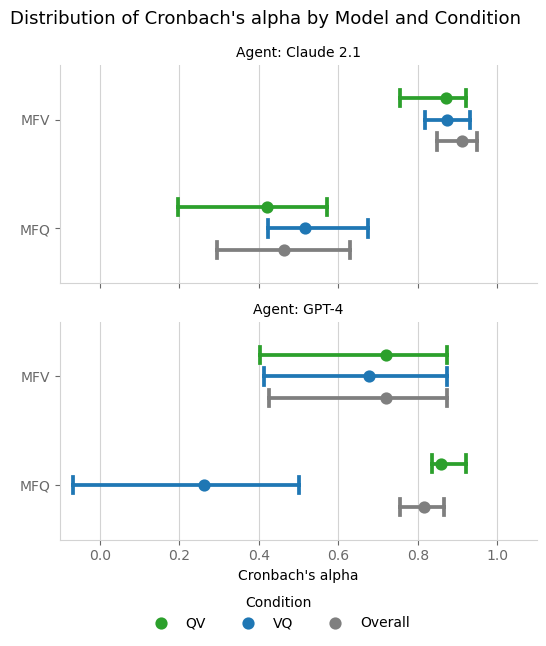

In [11]:
g = sns.catplot(
    row="agent",
    hue="condition",
    x="alpha",
    sharex=True,
    y="scale",
    kind='point',
    errorbar=("pi", 100),
    capsize=0.15,
    linestyles="none",
    dodge=.4,
    data=cronbach_df_simple.dropna().query("agent != 'Human'"),
    height=3,
    aspect=1.5,
    margin_titles=False,
    legend=True,
    order=[
        "MFV",
        "MFQ",
    ],
    # alpha=0.95,
    palette=["#2ca02c", "#1f77b4", "#7f7f7f"],
    hue_order=["qv", "vq", "overall"],
)
g.set_ylabels("")
g.set_xlabels("Cronbach's alpha")
# remove x axis label from center plot to make location for legend
g.axes[0][0].set_xlabel("")
# alter x limits
g.axes[0][0].set_xlim(-0.1, 1.1)
# titles left aligned
g.set_titles("Agent: {row_name}",)
g.figure.suptitle("Distribution of Cronbach's alpha by Model and Condition", ha="left", x=0.01, fontsize=13)
g.figure.subplots_adjust(top=0.85)
g.figure.tight_layout()
# set legend to bottom
g._legend.remove()
g.figure.legend(ncols=3,  title="Condition", loc="lower center", bbox_to_anchor=(0.5, -0.075), frameon=False, handles=g._legend_data.values(), labels=["QV", "VQ", "Overall"])
g.figure.savefig(figs_dir / "cronbachs_condition.png", dpi=300, bbox_inches="tight")
g.figure.savefig(figs_dir / "cronbachs_condition.pdf", dpi=300, bbox_inches="tight")


## Cronbach by agent

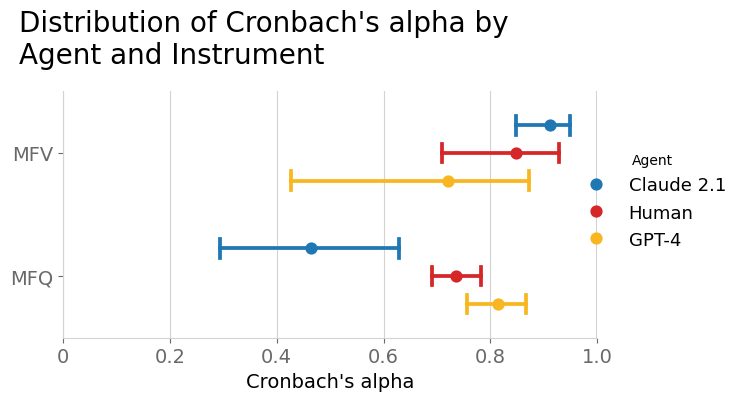

In [12]:
# increase fontsize for this single plot

g = sns.catplot(
    col="condition",
    hue="agent",
    x="alpha",
    y="scale",
    # jitter=0.28,
    # alpha=0.65,
    kind='point',
    estimator="mean",
    errorbar=("pi", 100),
    capsize=0.15,
    linestyles="none",
    dodge=.45,
    data=cronbach_df_simple.dropna().query("condition == 'overall'"),
    height=4,
    aspect=1.2,
    margin_titles=False,
    legend=True,
    order=[
        "MFV",
        "MFQ",
    ],
    palette=["#1f77b4", "#d62728", "#f8b620"],
    hue_order=["Claude 2.1", "Human", "GPT-4"],
)
g.set_ylabels("", fontsize=14)
g.set_xlabels("Cronbach's alpha", fontsize=14)
# increase ticks fontsize
# remove x axis label from center plot to make location for legend
# g.axes[0][1].set_xlabel("")
g.set_titles("")
# align title left
g.figure.suptitle("Distribution of Cronbach's alpha by\nAgent and Instrument", x=0.02, ha="left", fontsize=20)
g.figure.subplots_adjust(top=0.85)
g.figure.tight_layout()
# set legend to bottom
g.axes[0][0].set_xlim(0, 1)
g.set_xticklabels(labels=[0, 0.2, 0.4, 0.6, 0.8, 1.0], step=.2, fontsize=14)
g.set_yticklabels(fontsize=14)
# force grid at 1.0
g.axes[0][0].axvline(x=1, color="lightgray", linestyle="-")
g._legend.remove()
g.figure.legend(ncols=1,  title="Agent", loc="center right", frameon=False, bbox_to_anchor=(1.215, 0.5), fontsize=13)
g.figure.savefig(figs_dir / "cronbachs.png", dpi=300, bbox_inches="tight")
g.figure.savefig(figs_dir / "cronbachs.pdf", dpi=300, bbox_inches="tight")


## By foundation

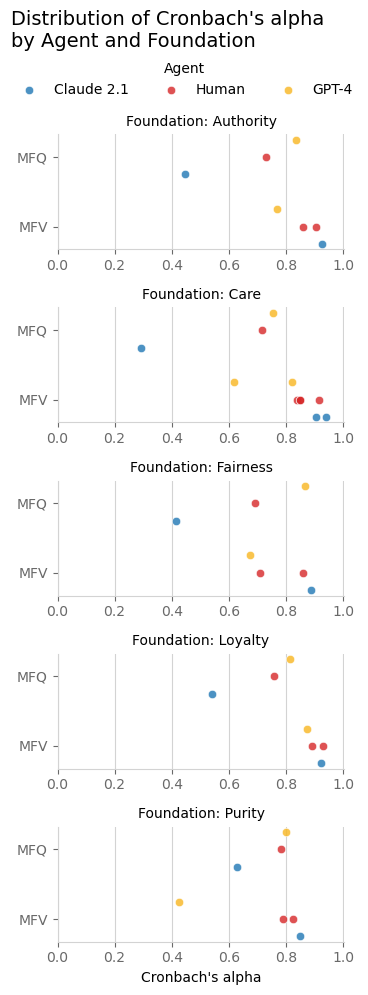

In [13]:
g = sns.FacetGrid(
    data=cronbach_df_simple.replace({"Care (e)": "Care", "Care (p)": "Care"})
    .query("foundation != 'Liberty' and condition == 'overall'")
    .sort_values("foundation"),  # .query("condition != 'overall'").dropna(),
    row="foundation",
    height=1.8,
    aspect=2,
    margin_titles=False,
    hue="agent",
    palette=["#1f77b4", "#d62728", "#f8b620"],
    hue_order=["Claude 2.1", "Human", "GPT-4"],
    sharex=False,
    # s=30,
    # order=[
    # "MFV",
    # "MFQ",
    # ],
)

g.map(
    sns.scatterplot,
    "alpha",
    "agent_instrument_y",
    legend=True,
    alpha=0.8,
)

g.set_ylabels("")
g.set_xlabels("Cronbach's alpha")
g.set_titles("Foundation: {row_name}", fontsize=13)
g.figure.legend(labels=["Claude 2.1", "Human", "GPT-4"], ncols=3,  title="Agent", loc="lower center", bbox_to_anchor=(0.5, 0.99), frameon=False)
# set xlims
# fix axis placement
for ax in g.axes:
    ax[0].set_axisbelow(True)
    ax[0].yaxis.grid(False)
    ax[0].set_xlim(0, 1.005)
# fix y axis
plt.yticks([1, 5], ["MFV", "MFQ"])
g.figure.suptitle("Distribution of Cronbach's alpha\nby Agent and Foundation", x=0.02, ha="left", fontsize=14, y=1.10,)

g.figure.savefig(figs_dir / "cronbachs_by_foundation.png", dpi=300, bbox_inches="tight")
g.figure.savefig(figs_dir / "cronbachs_by_foundation.pdf", dpi=300, bbox_inches="tight")

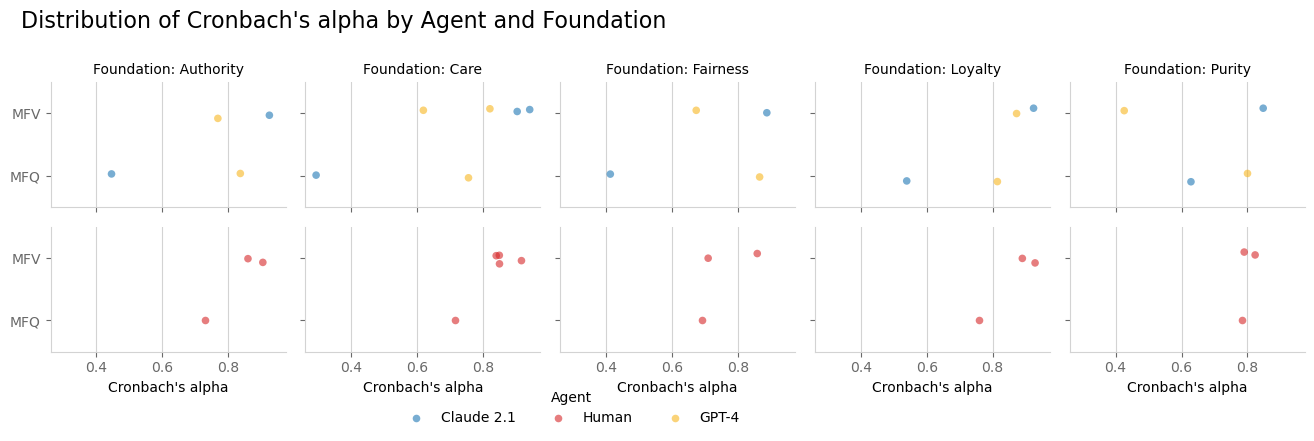

In [14]:
g = sns.catplot(
    col="foundation",
    # col_wrap=3,
    row="type_agent",
    x="alpha",
    y="scale",
    hue="agent",
    palette=["#1f77b4", "#d62728", "#f8b620"],
    hue_order=["Claude 2.1", "Human", "GPT-4"],
    # row_order=["Claude 2.1", "Human", "GPT-4"],
    alpha=0.6,
    # jitter=0.28,
    order=[
        "MFV",
        "MFQ",
    ],
    data=cronbach_df.replace({"Care (e)": "Care", "Care (p)": "Care"})
    .query("foundation != 'Liberty' and condition == 'overall'")
    .sort_values("foundation"),  # .query("condition != 'overall'").dropna(),
    height=2,
    aspect=1.2,
    margin_titles=False,
    legend=True,
    s=30,
)

g.set_ylabels("")
g.set_xlabels("Cronbach's alpha")
g.set_titles("Foundation: {col_name}", fontsize=13)
# remove title from rows after first
for i, ax in enumerate(g.axes):
    if i != 0:
        for a in ax:
            a.set_title("")
g._legend.remove()
g.figure.suptitle("Distribution of Cronbach's alpha by Agent and Foundation", x=0.02, ha="left", fontsize=16, y=1.0,),
g.figure.subplots_adjust(top=0.925)
g.figure.tight_layout()
# set legend to bottom
g.figure.legend(ncols=3,  title="Agent", loc="lower center", bbox_to_anchor=(0.435, -0.07), frameon=False)


# Visualizations including MFQ different parts

## Condition comparison

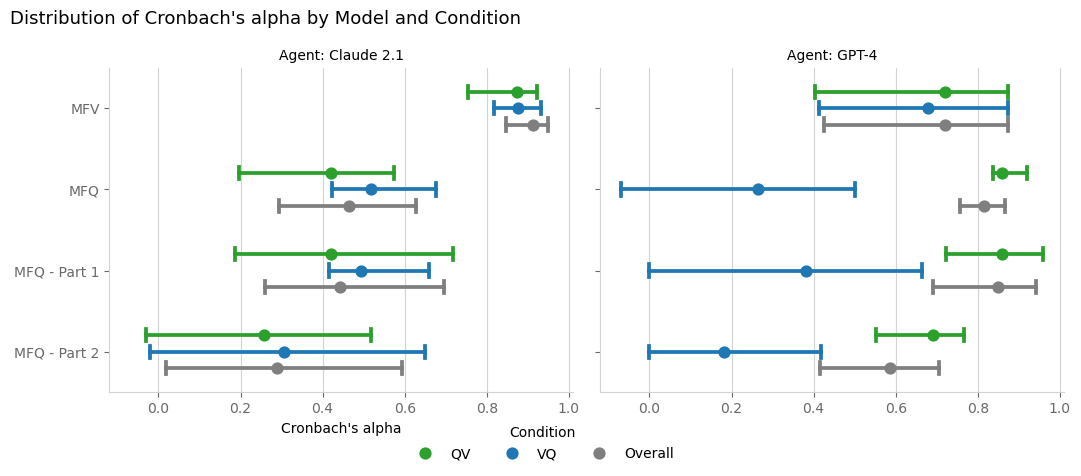

In [15]:
g = sns.catplot(
    col="agent",
    hue="condition",
    x="alpha",
    y="scale",
    kind='point',
    errorbar=("pi", 100),
    capsize=0.15,
    linestyles="none",
    dodge=.4,
    data=cronbach_df.dropna().query("agent != 'Human'"),
    height=4.5,
    aspect=1.1,
    margin_titles=False,
    legend=True,
    order=[
        "MFV",
        "MFQ",
        "MFQ - Part 1",
        "MFQ - Part 2",
    ],
    # alpha=0.95,
    palette=["#2ca02c", "#1f77b4", "#7f7f7f"],
    hue_order=["qv", "vq", "overall"],
)
g.set_ylabels("")
g.set_xlabels("Cronbach's alpha")
# remove x axis label from center plot to make location for legend
g.axes[0][1].set_xlabel("")
# titles left aligned
g.set_titles("Agent: {col_name}",)
g.figure.suptitle("Distribution of Cronbach's alpha by Model and Condition", ha="left", x=0.01, fontsize=13)
g.figure.subplots_adjust(top=0.85)
g.figure.tight_layout()
# set legend to bottom
g._legend.remove()
g.figure.legend(ncols=3,  title="Condition", loc="lower center", bbox_to_anchor=(0.5, -0.05), frameon=False, handles=g._legend_data.values(), labels=["QV", "VQ", "Overall"])
g.figure.savefig(split_mfq_dir / "cronbachs_condition.png", dpi=300, bbox_inches="tight")
g.figure.savefig(split_mfq_dir / "cronbachs_condition.pdf", dpi=300, bbox_inches="tight")


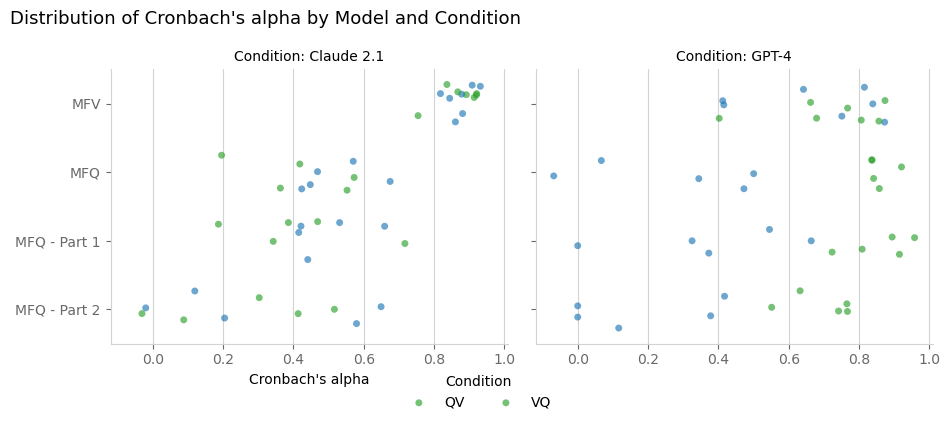

In [16]:
g = sns.catplot(
    col="agent",
    hue="condition",
    x="alpha",
    y="scale",
    jitter=0.28,
    data=cronbach_df.dropna().query("condition != 'overall'"),
    height=4,
    aspect=1.1,
    margin_titles=False,
    legend=True,
    order=[
        "MFV",
        "MFQ",
        "MFQ - Part 1",
        "MFQ - Part 2",
    ],
    alpha=0.65,
    palette=["#2ca02c", "#1f77b4"],
    hue_order=["qv", "vq"],
)
g.set_ylabels("")
g.set_xlabels("Cronbach's alpha")
# remove x axis label from center plot to make location for legend
g.axes[0][1].set_xlabel("")
# titles left aligned
g.set_titles("Condition: {col_name}",)
g.figure.suptitle("Distribution of Cronbach's alpha by Model and Condition", ha="left", x=0.01, fontsize=13)
g.figure.subplots_adjust(top=0.85)
g.figure.tight_layout()
# set legend to bottom
g._legend.remove()
g.figure.legend(ncols=4,  title="Condition", loc="lower center", bbox_to_anchor=(0.5, -0.05), frameon=False, labels=["QV", "VQ"])
# g.figure.savefig("figs/cronbachs_condition.png", dpi=300, bbox_inches="tight")
# g.figure.savefig("figs/cronbachs_condition.pdf", dpi=300, bbox_inches="tight")

# usar 3 cores (1 por agente) reduzir opacidade (0.4) e vai ajustando - plotar na mesma linha
# ou fazer uma linha so col por agente - manter relacao consistente com grafico seguitne para condicoes


# Cronbach by agent

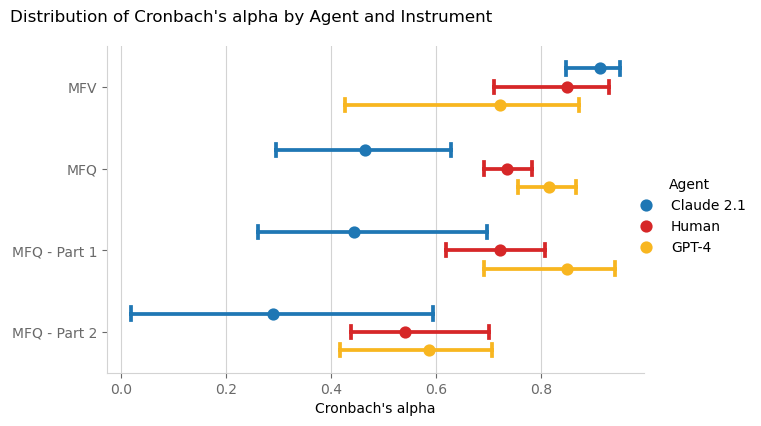

In [17]:
g = sns.catplot(
    col="condition",
    hue="agent",
    x="alpha",
    y="scale",
    # jitter=0.28,
    # alpha=0.65,
    kind='point',
    errorbar=("pi", 100),
    capsize=0.15,
    linestyles="none",
    dodge=.45,
    data=cronbach_df.dropna().query("condition == 'overall'"),
    height=4.3,
    aspect=1.25,
    margin_titles=False,
    legend=True,
    order=[
        "MFV",
        "MFQ",
        "MFQ - Part 1",
        "MFQ - Part 2",
    ],
    palette=["#1f77b4", "#d62728", "#f8b620"],
    hue_order=["Claude 2.1", "Human", "GPT-4"],
)
g.set_ylabels("")
g.set_xlabels("Cronbach's alpha")
# remove x axis label from center plot to make location for legend
# g.axes[0][1].set_xlabel("")
g.set_titles("")
# align title left
g.figure.suptitle("Distribution of Cronbach's alpha by Agent and Instrument", x=0.02, ha="left")
g.figure.subplots_adjust(top=0.85)
g.figure.tight_layout()
# set legend to bottom
g._legend.remove()
g.figure.legend(ncols=1,  title="Agent", loc="center right", frameon=False, bbox_to_anchor=(1.15, 0.5))
g.figure.savefig(split_mfq_dir / "cronbachs.png", dpi=300, bbox_inches="tight")
g.figure.savefig(split_mfq_dir / "cronbachs.pdf", dpi=300, bbox_inches="tight")


## By foundation

In [18]:
cronbach_df.query("condition == 'overall' and foundation == 'Liberty'")

,scale,foundation,condition,agent,alpha,type_agent,agent_instrument_y
120,MFV,Liberty,overall,GPT-4,0.861775,AI,2
123,MFV,Liberty,overall,Claude 2.1,0.949510,AI,0
137,MFV,Liberty,overall,Human,0.823107,Human,1
157,MFV,Liberty,overall,Human,0.830000,Human,1


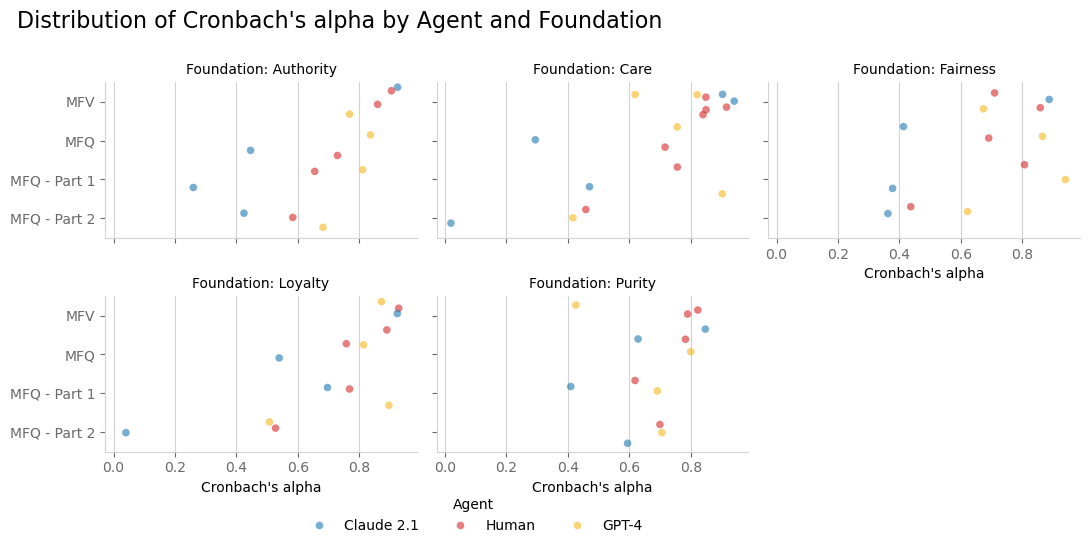

In [19]:
g = sns.catplot(
    col="foundation",
    col_wrap=3,
    # row="type_agent",
    x="alpha",
    y="scale",
    hue="agent",
    palette=["#1f77b4", "#d62728", "#f8b620"],
    hue_order=["Claude 2.1", "Human", "GPT-4"],
    # row_order=["Claude 2.1", "Human", "GPT-4"],
    alpha=0.6,
    jitter=0.4,
    order=[
        "MFV",
        "MFQ",
        "MFQ - Part 1",
        "MFQ - Part 2",
    ],
    data=cronbach_df.replace({"Care (e)": "Care", "Care (p)": "Care"})
    .query("foundation != 'Liberty' and condition == 'overall'")
    .sort_values("foundation"),  # .query("condition != 'overall'").dropna(),
    height=2.5,
    aspect=1.3,
    margin_titles=False,
    legend=True,
    s=30,
)

g.set_ylabels("")
g.set_xlabels("Cronbach's alpha")
g.set_titles("Foundation: {col_name}", fontsize=13)
# remove title from rows after first

g._legend.remove()
g.figure.suptitle("Distribution of Cronbach's alpha by Agent and Foundation", x=0.02, ha="left", fontsize=16, y=1.0,),
g.figure.subplots_adjust(top=0.925)
g.figure.tight_layout()
# set legend to bottom
g.figure.legend(ncols=3,  title="Agent", loc="lower center", bbox_to_anchor=(0.435, -0.07), frameon=False)

# g.figure.savefig("figs/cronbachs_by_foundation.png", dpi=300, bbox_inches="tight")
# g.figure.savefig("figs/cronbachs_by_foundation.pdf", dpi=300, bbox_inches="tight")


# reduzir peso das linhas (mudar eixo pra cinza), tick labels menores cinza escura, grafico na horizontal
# mexer na opacidade e ajustar cores

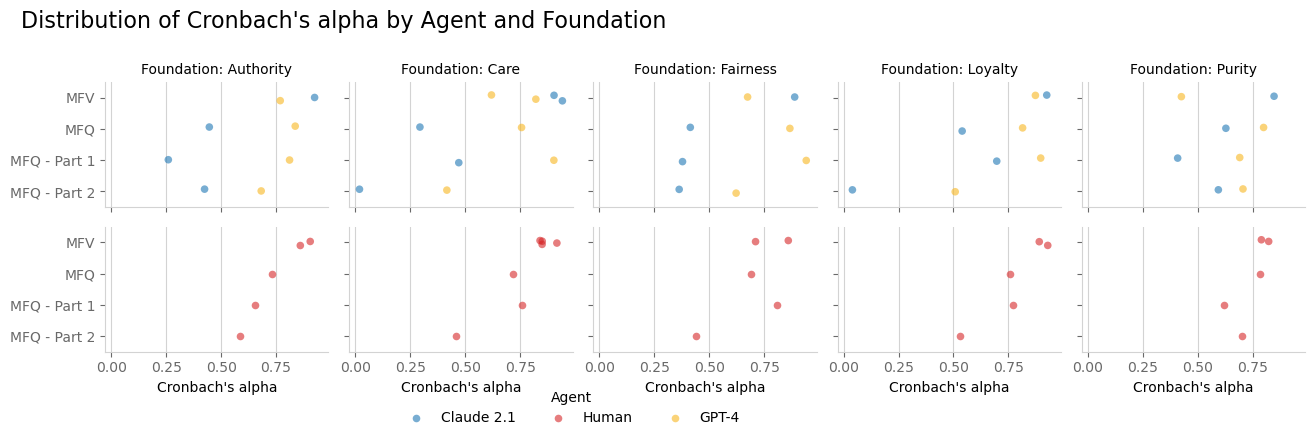

In [20]:
g = sns.catplot(
    col="foundation",
    # col_wrap=3,
    row="type_agent",
    x="alpha",
    y="scale",
    hue="agent",
    palette=["#1f77b4", "#d62728", "#f8b620"],
    hue_order=["Claude 2.1", "Human", "GPT-4"],
    # row_order=["Claude 2.1", "Human", "GPT-4"],
    alpha=0.6,
    # jitter=0.28,
    order=[
        "MFV",
        "MFQ",
        "MFQ - Part 1",
        "MFQ - Part 2",
    ],
    data=cronbach_df.replace({"Care (e)": "Care", "Care (p)": "Care"})
    .query("foundation != 'Liberty' and condition == 'overall'")
    .sort_values("foundation"),  # .query("condition != 'overall'").dropna(),
    height=2,
    aspect=1.2,
    margin_titles=False,
    legend=True,
    s=30,
)

g.set_ylabels("")
g.set_xlabels("Cronbach's alpha")
g.set_titles("Foundation: {col_name}", fontsize=13)
# remove title from rows after first
for i, ax in enumerate(g.axes):
    if i != 0:
        for a in ax:
            a.set_title("")
g._legend.remove()
g.figure.suptitle("Distribution of Cronbach's alpha by Agent and Foundation", x=0.02, ha="left", fontsize=16, y=1.0,),
g.figure.subplots_adjust(top=0.925)
g.figure.tight_layout()
# set legend to bottom
g.figure.legend(ncols=3,  title="Agent", loc="lower center", bbox_to_anchor=(0.435, -0.07), frameon=False)

g.figure.savefig(split_mfq_dir / "cronbachs_by_foundation.png", dpi=300, bbox_inches="tight")
g.figure.savefig(split_mfq_dir / "cronbachs_by_foundation.pdf", dpi=300, bbox_inches="tight")
